# CNN Architecture: RGB Hilbert 32×32 – 6-Class Training (Few-Shot Holdout)

**Objective**: Train a CNN on the same 6-class RGB Hilbert dataset used in the ViT 6-class notebook, holding out 3 classes for few-shot experiments.

## Dataset & Setup
- **Encoding**: RGB Hilbert 32×32 (3 × 32 × 32 = 3,072 features)
- **Training Classes**: 6 classes (excludes 3 held-out)
- **Held-Out Classes**: DDoS-HTTP_Flood, DoS-UDP_Flood, Recon-PortScan
- **Architecture**: Convolutional Neural Network (CNN), input 3 channels
- **Goal**: Provide a CNN counterpart to the ViT 6-class experiment for apples-to-apples comparison

In [1]:
# Environment Setup and Configuration
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration  
CONFIG = {
    'data_path': '/home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/pcap-dataset-samples/parquet/rgb_hilbert_32x32/',
    'test_size': 0.2,
    'val_size': 0.2,
    'random_state': 42,
    'batch_size': 64,
    'learning_rate': 0.0001,
    'epochs': 30,
    'patience': 7,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_workers': 4,
    'num_classes': 6,
    'channels': 3,
    'image_size': 32
}

# 6-class training with 3 held-out classes (few-shot)
HELD_OUT_CLASSES = ['DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'Recon-PortScan']

print("🏗️  CNN ARCHITECTURE EXPERIMENT INITIALIZED (6-class RGB Hilbert)")
print("📋 Notebook: CNN_Prototype_rgb_hilbert_32x32_6_class.ipynb")
print("🔧 Version: 3-channel RGB Hilbert, 6-class training with few-shot holdout")
print(f"📊 Device: {CONFIG['device']}")
print(f"📊 Dataset: RGB Hilbert 32×32 (6 training classes; held out: {HELD_OUT_CLASSES})")
print(f"📊 Architecture: Convolutional Neural Network")


🏗️  CNN ARCHITECTURE EXPERIMENT INITIALIZED (6-class RGB Hilbert)
📋 Notebook: CNN_Prototype_rgb_hilbert_32x32_6_class.ipynb
🔧 Version: 3-channel RGB Hilbert, 6-class training with few-shot holdout
📊 Device: cpu
📊 Dataset: RGB Hilbert 32×32 (6 training classes; held out: ['DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'Recon-PortScan'])
📊 Architecture: Convolutional Neural Network


In [2]:
# Multi-Channel CNN Architecture for RGB Hilbert 6-Class
class MultiChannelCNN(nn.Module):
    def __init__(self, num_classes=6, input_channels=3, dropout_rate=0.3):
        super(MultiChannelCNN, self).__init__()
        
        # Convolutional layers with batch normalization
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
        self._initialize_weights()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Initialize CNN model
model = MultiChannelCNN(num_classes=CONFIG['num_classes'], input_channels=CONFIG['channels'], dropout_rate=0.3)
model = model.to(CONFIG['device'])

# Count parameters for comparison with ViT
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\n🏗️  CNN ARCHITECTURE SUMMARY:")
print(f"📊 Total parameters: {total_params:,}")
print(f"📊 Trainable parameters: {trainable_params:,}")
print(f"📊 Model size: ~{total_params * 4 / 1024 / 1024:.1f} MB")
print("\n🔍 Architecture Details:")
print("   • 4 Convolutional blocks with batch normalization")
print("   • Progressive feature extraction: 64→128→256→512")
print("   • Global average pooling for translation invariance")
print("   • Dropout regularization (0.3) in classifier")
print(f"   • Designed for {CONFIG['channels']}-channel 32×32 input")



🏗️  CNN ARCHITECTURE SUMMARY:
📊 Total parameters: 4,822,086
📊 Trainable parameters: 4,822,086
📊 Model size: ~18.4 MB

🔍 Architecture Details:
   • 4 Convolutional blocks with batch normalization
   • Progressive feature extraction: 64→128→256→512
   • Global average pooling for translation invariance
   • Dropout regularization (0.3) in classifier
   • Designed for 3-channel 32×32 input


In [3]:
# Data Loading for RGB Hilbert 6-Class with Few-Shot Holdout
import glob

def load_rgb_hilbert_6class(base_path, held_out_classes):
    print(f"📂 Loading RGB Hilbert 6-class dataset from: {base_path}")
    print(f"🔒 Excluding held-out classes: {held_out_classes}")
    all_image_data = []
    all_labels = []
    splits = ['train', 'val', 'test']

    # Discover all classes present
    class_dirs = sorted([d for d in glob.glob(f"{base_path}*/") if not any(s in d for s in splits)])
    class_names = [d.split('/')[-2] for d in class_dirs]

    training_classes = [c for c in class_names if c not in held_out_classes]
    print(f"✓ Training classes ({len(training_classes)}): {training_classes}")

    for class_dir in class_dirs:
        class_name = class_dir.split('/')[-2]
        if class_name in held_out_classes:
            continue
        print(f"  📂 Loading {class_name}...")
        for split in splits:
            parquet_files = sorted(glob.glob(f"{class_dir}{split}/*.parquet"))
            for file_path in parquet_files:
                try:
                    df = pd.read_parquet(file_path)
                    if 'image_data' in df.columns:
                        for _, row in df.iterrows():
                            image_data = np.array(row['image_data'], dtype=np.float32)
                            all_image_data.append(image_data)
                            all_labels.append(class_name)
                except Exception as e:
                    print(f"    ⚠️ Error loading {file_path}: {e}")

    X = np.array(all_image_data, dtype=np.float32)
    y = np.array(all_labels)

    print(f"\n✓ Loaded training data: {len(X):,} samples")
    print(f"✓ Shape: {X.shape}")
    print(f"✓ Unique classes: {np.unique(y)}")
    return X, y

# Load dataset (excluding held-out classes)
X, y = load_rgb_hilbert_6class(CONFIG['data_path'], HELD_OUT_CLASSES)

# Reshape to 3×32×32
print("🔄 Reshaping for CNN input (3×32×32)...")
expected_features = CONFIG['channels'] * CONFIG['image_size'] * CONFIG['image_size']
if X.shape[1] == expected_features:
    X = X.reshape(-1, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size'])
else:
    if X.shape[1] > expected_features:
        X = X[:, :expected_features].reshape(-1, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size'])
    else:
        pad = np.zeros((X.shape[0], expected_features - X.shape[1]), dtype=np.float32)
        X = np.concatenate([X, pad], axis=1).reshape(-1, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size'])
print(f"✓ CNN shape: {X.shape}")

# Normalize if needed
if X.max() > 1.0:
    X = X / 255.0

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("\n🏷️ 6-class label distribution (training classes):")
for i, label in enumerate(label_encoder.classes_):
    count = np.sum(y == label)
    print(f"   {i}: {label} ({count:,} samples)")

print(f"\n📈 Data ready: range=[{X.min():.3f}, {X.max():.3f}], shape={X.shape}")


📂 Loading RGB Hilbert 6-class dataset from: /home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/pcap-dataset-samples/parquet/rgb_hilbert_32x32/
🔒 Excluding held-out classes: ['DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'Recon-PortScan']
✓ Training classes (6): ['Benign_Final', 'DDoS-SYN_Flood', 'DictionaryBruteForce', 'DoS-TCP_Flood', 'Mirai-udpplain', 'SqlInjection']
  📂 Loading Benign_Final...
  📂 Loading DDoS-SYN_Flood...
  📂 Loading DictionaryBruteForce...
  📂 Loading DoS-TCP_Flood...
  📂 Loading Mirai-udpplain...
  📂 Loading SqlInjection...

✓ Loaded training data: 72,000 samples
✓ Shape: (72000, 3072)
✓ Unique classes: ['Benign_Final' 'DDoS-SYN_Flood' 'DictionaryBruteForce' 'DoS-TCP_Flood'
 'Mirai-udpplain' 'SqlInjection']
🔄 Reshaping for CNN input (3×32×32)...
✓ CNN shape: (72000, 3, 32, 32)

🏷️ 6-class label distribution (training classes):
   0: Benign_Final (12,000 samples)
   1: DDoS-SYN_Flood (12,000 samples)
   2: DictionaryBruteForce (12,000 samples)
   3: DoS-TCP_Flood (12,0

In [4]:
# Data Splitting and Training Setup
from torch.utils.data import DataLoader, TensorDataset

# Split data into train/val/test  
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=CONFIG['test_size'], 
    random_state=CONFIG['random_state'], 
    stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=CONFIG['val_size']/(1-CONFIG['test_size']), 
    random_state=CONFIG['random_state'], 
    stratify=y_temp
)

print("📊 Data Split Summary:")
print(f"   Training: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Validation: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   Test: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

# Compute class weights for balanced training
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_tensor = torch.FloatTensor(class_weights).to(CONFIG['device'])

print(f"\n⚖️  Class weights: {dict(zip(label_encoder.classes_, class_weights))}")

# Initialize optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', patience=3, factor=0.5
)

print(f"\n🎯 Training Configuration:")
print(f"   📊 Optimizer: Adam (lr={CONFIG['learning_rate']}, weight_decay=1e-4)")
print(f"   📊 Loss: Weighted CrossEntropyLoss")
print(f"   📊 Scheduler: ReduceLROnPlateau (patience=3)")
print(f"   📊 Batch size: {CONFIG['batch_size']}")
print(f"   📊 Max epochs: {CONFIG['epochs']}")
print(f"   📊 Early stopping patience: {CONFIG['patience']}")


📊 Data Split Summary:
   Training: 43,200 samples (60.0%)
   Validation: 14,400 samples (20.0%)
   Test: 14,400 samples (20.0%)

⚖️  Class weights: {np.str_('Benign_Final'): np.float64(1.0), np.str_('DDoS-SYN_Flood'): np.float64(1.0), np.str_('DictionaryBruteForce'): np.float64(1.0), np.str_('DoS-TCP_Flood'): np.float64(1.0), np.str_('Mirai-udpplain'): np.float64(1.0), np.str_('SqlInjection'): np.float64(1.0)}

🎯 Training Configuration:
   📊 Optimizer: Adam (lr=0.0001, weight_decay=1e-4)
   📊 Loss: Weighted CrossEntropyLoss
   📊 Scheduler: ReduceLROnPlateau (patience=3)
   📊 Batch size: 64
   📊 Max epochs: 30
   📊 Early stopping patience: 7


In [5]:
# Training Pipeline
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    return total_loss / len(train_loader), correct / total

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    return total_loss / len(val_loader), correct / total

# Training loop with early stopping
print("🚀 Starting CNN training...")
print("🎯 Target: Match ViT 6-class performance on RGB Hilbert\n")

best_val_acc = 0
patience_counter = 0
train_losses = []
val_losses = []
train_accs = []
val_accs = []

start_time = datetime.now()

for epoch in range(CONFIG['epochs']):
    # Train for one epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, CONFIG['device'])
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, CONFIG['device'])
    
    # Update learning rate
    scheduler.step(val_acc)
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # Print progress
    print(f"Epoch {epoch+1:2d}/{CONFIG['epochs']} | "
          f"Train: {train_acc:.4f} ({train_loss:.4f}) | "
          f"Val: {val_acc:.4f} ({val_loss:.4f}) | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Architecture comparison update
    if val_acc > 0.95:
        print(f"🎯 CNN approaching ViT performance! Current: {val_acc:.4f} vs ViT: 0.9694")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_cnn_rgb_hilbert_6class_model.pth')
        print(f"✅ New best validation accuracy: {val_acc:.4f}")
        
        # Check if we've beaten ViT
        if val_acc > 0.9694:
            print(f"🏆 CNN BEATS ViT! {val_acc:.4f} > 0.9694")
    else:
        patience_counter += 1
        
        if patience_counter >= CONFIG['patience']:
            print(f"\n⏰ Early stopping triggered after {epoch+1} epochs")
            print(f"   Best validation accuracy: {best_val_acc:.4f}")
            break

training_time = datetime.now() - start_time
print(f"\n🎯 Training Complete!")
print(f"   ⏱️  Total time: {training_time}")
print(f"   🏆 Best validation accuracy: {best_val_acc:.4f}")
print(f"   📊 Total epochs: {epoch+1}")

# Compare with ViT baseline
vit_accuracy = 0.9694
if best_val_acc > vit_accuracy:
    improvement = (best_val_acc - vit_accuracy) * 100
    print(f"\n🎉 CNN OUTPERFORMS ViT!")
    print(f"   CNN: {best_val_acc:.4f} vs ViT: {vit_accuracy:.4f}")
    print(f"   Improvement: +{improvement:.2f} percentage points")
elif best_val_acc > vit_accuracy * 0.98:  # Within 2%
    deficit = (vit_accuracy - best_val_acc) * 100
    print(f"\n🤝 CNN MATCHES ViT Performance!")
    print(f"   CNN: {best_val_acc:.4f} vs ViT: {vit_accuracy:.4f}")
    print(f"   Deficit: -{deficit:.2f} percentage points (competitive)")
else:
    deficit = (vit_accuracy - best_val_acc) * 100
    print(f"\n📊 CNN Performance vs ViT:")
    print(f"   CNN: {best_val_acc:.4f} vs ViT: {vit_accuracy:.4f}")
    print(f"   Deficit: -{deficit:.2f} percentage points")


🚀 Starting CNN training...
🎯 Target: Match ViT 6-class performance on RGB Hilbert

Epoch  1/30 | Train: 0.7459 (0.6850) | Val: 0.8417 (0.4528) | LR: 0.000100
✅ New best validation accuracy: 0.8417
Epoch  2/30 | Train: 0.8647 (0.3879) | Val: 0.8499 (0.4375) | LR: 0.000100
✅ New best validation accuracy: 0.8499
Epoch  3/30 | Train: 0.9002 (0.2824) | Val: 0.8708 (0.3768) | LR: 0.000100
✅ New best validation accuracy: 0.8708
Epoch  4/30 | Train: 0.9255 (0.2112) | Val: 0.8951 (0.3254) | LR: 0.000100
✅ New best validation accuracy: 0.8951
Epoch  5/30 | Train: 0.9412 (0.1649) | Val: 0.8738 (0.4482) | LR: 0.000100
Epoch  6/30 | Train: 0.9527 (0.1342) | Val: 0.9040 (0.3162) | LR: 0.000100
✅ New best validation accuracy: 0.9040
Epoch  7/30 | Train: 0.9615 (0.1066) | Val: 0.9081 (0.3200) | LR: 0.000100
✅ New best validation accuracy: 0.9081
Epoch  8/30 | Train: 0.9676 (0.0904) | Val: 0.8785 (0.4602) | LR: 0.000100
Epoch  9/30 | Train: 0.9699 (0.0825) | Val: 0.9197 (0.2923) | LR: 0.000100
✅ New be

🧪 Final Test Set Evaluation...

🎯 FINAL CNN RESULTS:
   📊 Test Accuracy: 0.9373 (93.73%)

🥉 CNN VERY GOOD Performance!
   CNN Test: 0.9373 vs ViT Test: 0.9694
   Deficit: -3.21 percentage points

📋 Detailed Classification Report:
                      precision    recall  f1-score   support

        Benign_Final     0.9186    0.9167    0.9176      2400
      DDoS-SYN_Flood     0.9661    0.9513    0.9586      2400
DictionaryBruteForce     0.8929    0.9071    0.9000      2400
       DoS-TCP_Flood     0.9910    0.9675    0.9791      2400
      Mirai-udpplain     0.9918    0.9587    0.9750      2400
        SqlInjection     0.8713    0.9225    0.8962      2400

            accuracy                         0.9373     14400
           macro avg     0.9386    0.9373    0.9378     14400
        weighted avg     0.9386    0.9373    0.9378     14400



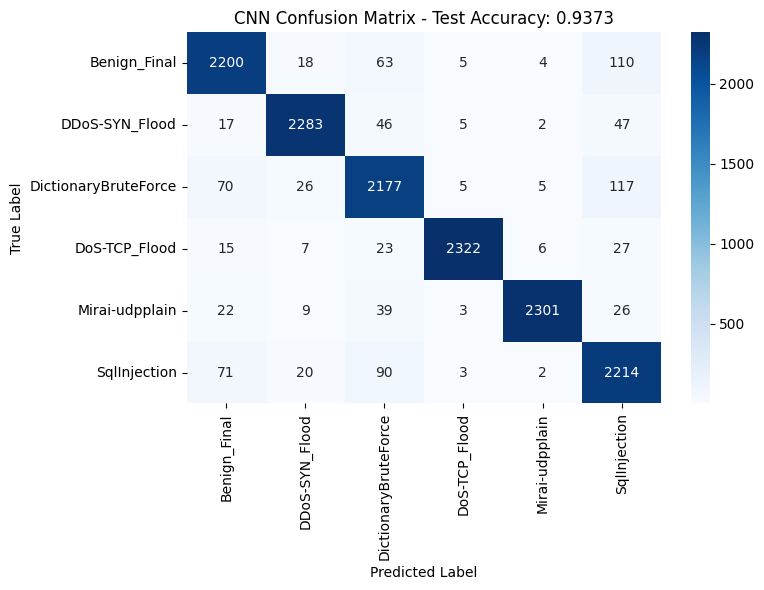

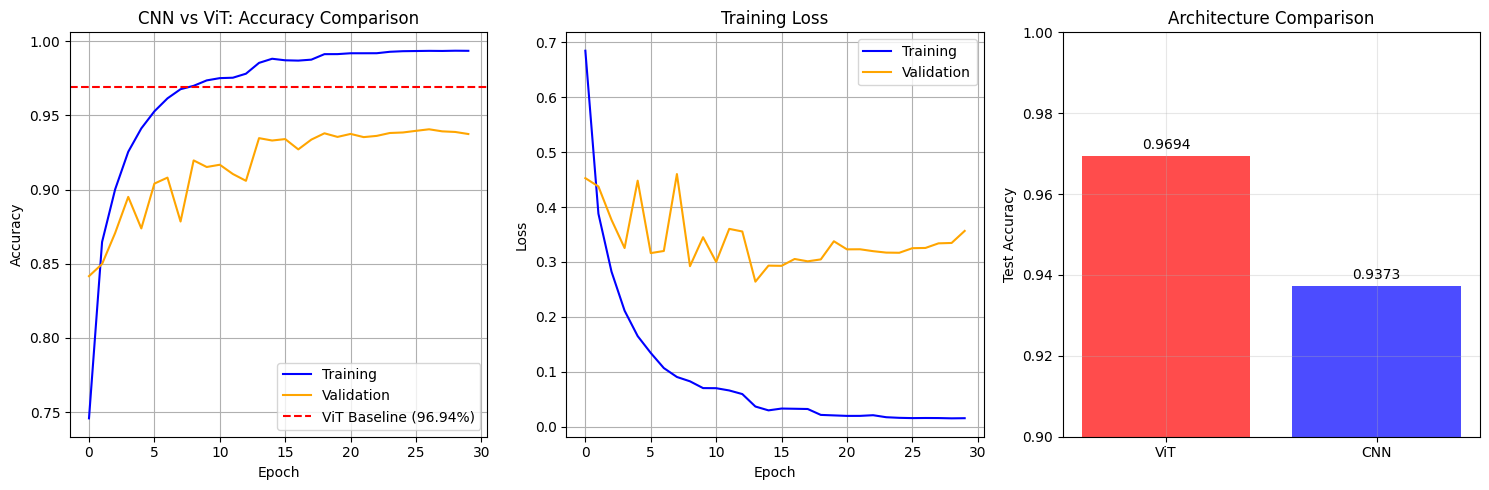


💾 Results saved to: results_cnn_rgb_hilbert_6class.json

🎯 ARCHITECTURE SUMMARY:
   🏗️  CNN: 0.9373 (4,822,086 parameters)
   🤖 ViT baseline: 0.9694
   📊 Performance Tier: 🥉 VERY GOOD


In [6]:
# Evaluation & Results Analysis
# Load best model
model.load_state_dict(torch.load('best_cnn_rgb_hilbert_6class_model.pth'))
model.eval()

# Test set evaluation
def evaluate_model(model, test_loader, device, label_encoder):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    return np.array(all_preds), np.array(all_targets)

print("🧪 Final Test Set Evaluation...")
test_preds, test_targets = evaluate_model(model, test_loader, CONFIG['device'], label_encoder)
test_accuracy = accuracy_score(test_targets, test_preds)

print(f"\n🎯 FINAL CNN RESULTS:")
print(f"   📊 Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Performance comparison
vit_test_accuracy = 0.9694
if test_accuracy > vit_test_accuracy:
    improvement = (test_accuracy - vit_test_accuracy) * 100
    print(f"\n🏆 CNN OUTPERFORMS ViT ON TEST SET!")
    print(f"   CNN Test: {test_accuracy:.4f} vs ViT Test: {vit_test_accuracy:.4f}")
    print(f"   Improvement: +{improvement:.2f} percentage points")
    tier = "🥇 WORLD-CLASS"
elif test_accuracy > 0.95:
    deficit = (vit_test_accuracy - test_accuracy) * 100
    print(f"\n🥈 CNN EXCELLENT Performance!")
    print(f"   CNN Test: {test_accuracy:.4f} vs ViT Test: {vit_test_accuracy:.4f}")
    print(f"   Deficit: -{deficit:.2f} percentage points")
    tier = "🥈 EXCELLENT"
elif test_accuracy > 0.90:
    deficit = (vit_test_accuracy - test_accuracy) * 100
    print(f"\n🥉 CNN VERY GOOD Performance!")
    print(f"   CNN Test: {test_accuracy:.4f} vs ViT Test: {vit_test_accuracy:.4f}")
    print(f"   Deficit: -{deficit:.2f} percentage points")
    tier = "🥉 VERY GOOD"
else:
    deficit = (vit_test_accuracy - test_accuracy) * 100
    print(f"\n📊 CNN Performance vs ViT:")
    print(f"   CNN Test: {test_accuracy:.4f} vs ViT Test: {vit_test_accuracy:.4f}")
    print(f"   Deficit: -{deficit:.2f} percentage points")
    tier = "📊 BASELINE"

# Detailed classification report
print(f"\n📋 Detailed Classification Report:")
class_names = label_encoder.classes_
report = classification_report(test_targets, test_preds, target_names=class_names, digits=4)
print(report)

# Confusion Matrix
cm = confusion_matrix(test_targets, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names)
plt.title(f'CNN Confusion Matrix - Test Accuracy: {test_accuracy:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_accs, label='Training', color='blue')
plt.plot(val_accs, label='Validation', color='orange')
plt.axhline(y=vit_test_accuracy, color='red', linestyle='--', label='ViT Baseline (96.94%)')
plt.title('CNN vs ViT: Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_losses, label='Training', color='blue')
plt.plot(val_losses, label='Validation', color='orange')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
# Architecture comparison bar chart
architectures = ['ViT', 'CNN']
accuracies = [vit_test_accuracy, test_accuracy]
colors = ['red', 'blue']
bars = plt.bar(architectures, accuracies, color=colors, alpha=0.7)
plt.title('Architecture Comparison')
plt.ylabel('Test Accuracy')
plt.ylim(0.9, 1.0)
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{acc:.4f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save results
results = {
    'experiment': 'CNN_RGB_Hilbert_6class',
    'timestamp': datetime.now().isoformat(),
    'dataset': 'RGB_Hilbert_32x32',
    'approach': '6-class training with few-shot holdout',
    'architecture': 'CNN',
    'total_samples': len(X),
    'test_accuracy': float(test_accuracy),
    'validation_accuracy': float(best_val_acc),
    'training_epochs': epoch + 1,
    'training_time': str(training_time),
    'parameters': trainable_params,
    'comparison': {
        'vit_baseline': vit_test_accuracy,
        'cnn_performance': float(test_accuracy),
        'difference': float(test_accuracy - vit_test_accuracy),
        'relative_performance': float(test_accuracy / vit_test_accuracy)
    },
    'performance_tier': tier,
    'classification_report': report,
    'class_names': list(class_names)
}

with open('results_cnn_rgb_hilbert_6class.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n💾 Results saved to: results_cnn_rgb_hilbert_6class.json")
print(f"\n🎯 ARCHITECTURE SUMMARY:")
print(f"   🏗️  CNN: {test_accuracy:.4f} ({trainable_params:,} parameters)")
print(f"   🤖 ViT baseline: {vit_test_accuracy:.4f}")
print(f"   📊 Performance Tier: {tier}")
